In [2]:
import os
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
model_path = ""
model = tf.keras.models.load_model(model_path)

In [4]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    
    # Ensure that the image has 3 channels (RGB)
    if image.shape[-1] == 4:
        image = image[..., :3]
    
    # Standard densenet preprocessing
    image = tf.keras.applications.densenet.preprocess_input(image)
    image = image[None, ...]
    return image

In [5]:
def generate_fgsm(image, epsilon=0.0001):
    image = tf.identity(image)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)

    gradient = tape.gradient(prediction, image)

    signed_grad = tf.sign(gradient)

    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)  

    return perturbed_image

In [12]:
base_dir = ""
target_dir = ""
class_names = ['benign', 'malignant']

In [13]:
for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    output_class_dir_fgsm = os.path.join(target_dir, class_name)

    os.makedirs(output_class_dir_fgsm, exist_ok=True)

    pbar = tqdm(os.listdir(class_dir), desc=class_name)

    for image_name in pbar:
        image_path = os.path.join(class_dir, image_name)
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_image(image_raw)
        image = preprocess(image)

        epsilon_fgsm = 1e-6 
        perturbed_image_fgsm = generate_fgsm(image, epsilon_fgsm)

        image_name_without_extension, extension = os.path.splitext(image_name)
        new_image_name_fgsm = f"{image_name_without_extension}_FGSM{extension}"

        output_image_path_fgsm = os.path.join(output_class_dir_fgsm, new_image_name_fgsm)
        perturbed_image_fgsm = tf.image.convert_image_dtype(perturbed_image_fgsm, tf.uint8)
        perturbed_image_encoded_fgsm = tf.image.encode_png(perturbed_image_fgsm[0])
        tf.io.write_file(output_image_path_fgsm, perturbed_image_encoded_fgsm)

benign:   0%|          | 0/250 [00:00<?, ?it/s]

malignant: 100%|██████████| 250/250 [01:00<00:00,  4.12it/s]


Found 792 files belonging to 2 classes.
Predictions:
 [1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0]
Labels:
 [0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
25/25 [==============================] - 4s 98ms/step - loss: 0.4934 - accuracy: 0.8081
Test accuracy : 0.808080792427063


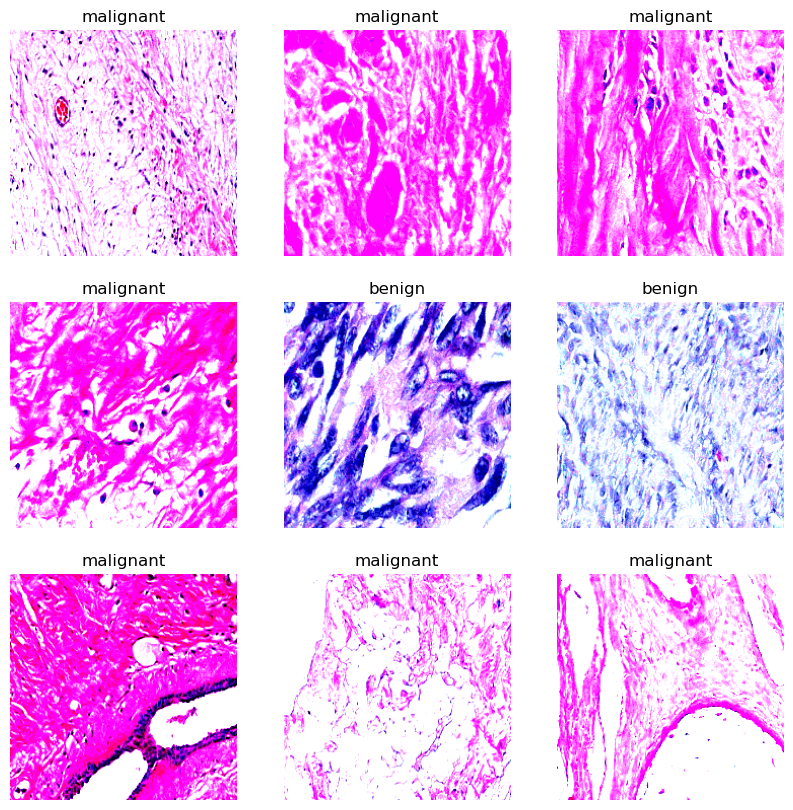

In [8]:
test_dir = ""

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

AUTOTUNE = tf.data.AUTOTUNE

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)